# Modules

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

from catboost import CatBoostClassifier
import xgboost as xgb

import optuna

# Processing

In [136]:
df = pd.read_csv("C:/Users/33782/Desktop/Mémoire F1/df_final_2.csv")

In [137]:
# Supposons que vous avez déjà importé votre DataFrame df_final

# Sélectionnez les colonnes à encoder
columns_to_encode = ["nationality"]

# Créez une instance de OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Adapter et transformer les colonnes sélectionnées
encoded_data = encoder.fit_transform(df[columns_to_encode])

# Créez un DataFrame avec les données encodées
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

# Supprimez les colonnes encodées du DataFrame d'origine
df.drop(columns=columns_to_encode, inplace=True)

# Concaténez le DataFrame original avec le DataFrame encodé
df_final = pd.concat([df, encoded_df], axis=1)

In [138]:
df_final.drop(columns="positionOrder", inplace=True)

In [139]:
# Create a list of columns excluding the one to move
cols = [col for col in df_final.columns if col != 'Top 3 Finish']

# Append the column to the end of the DataFrame
df_final = df_final[cols + ['Top 3 Finish']]

In [140]:
train_df = df_final[(df_final["year"] >= 2012) & (df_final["year"] <= 2022)]
test_df = df_final[(df_final["year"] == 2023)]


X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values


X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

In [141]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [114]:
# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

In [143]:
joblib.dump(scaler, 'scaler_GB.joblib')

['scaler_GB.joblib']

# Procédure d'évaluation

In [115]:
comparison_dict ={'model':[],
                  'score': []}

In [116]:
def evaluation(model):
    
    model.fit(X_train_scaled,y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    score = round(f1_score(y_test, y_pred),2)
    
    comparison_dict['score'].append(score)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    #N, train_score, val_score = learning_curve(model, X_train_scaled, y_train_resampled,
                                              #cv=8, scoring = "f1",
                                              #train_sizes = np.linspace(0.1,1,10))
    
    #plt.figure(figsize=(12,8))
    #plt.plot(N, train_score.mean(axis=1), label="Train score")
    #plt.plot(N, val_score.mean(axis=1), label="Validation score")
    #plt.legend(loc="best")

In [25]:
def learningcurve(title, model):
    
    
    train_sizes, train_scores, valid_scores = learning_curve(model,
                                                             X_train_scaled,
                                                             y_train_resampled,
                                                             train_sizes=[i/10 for i in range(1,11)])

    plt.figure(figsize=(9,3))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='training',marker='.', color='blue')
    plt.plot(train_sizes, valid_scores.mean(axis=1), label='validaiton',marker='.', color='orange')
    plt.title(f"Learning curve of the {title} model")
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.savefig(f'C:/Users/33782/Desktop/Mémoire F1/Learning curve/{title}.png')

# Modèles

In [117]:
AdaBoost = AdaBoostClassifier(n_estimators=160,
                              learning_rate=0.15826735517631804,
                              algorithm='SAMME.R',
                              random_state=42)

CatBoost = CatBoostClassifier(iterations=355,
                              learning_rate=0.0016319372622323079,
                              depth=10,
                              l2_leaf_reg=1.0615624230812226,
                              verbose=0,
                              random_state=42)

GB = GradientBoostingClassifier(learning_rate=0.0019772333924089505,
                                n_estimators=191,
                                max_depth=9,
                                min_samples_split=8,
                                min_samples_leaf=5,
                                random_state=42)

XGBoost = xgb.XGBClassifier(learning_rate= 0.004600984662122648,
                            n_estimators= 329,
                            max_depth= 8,
                            subsample= 1,
                            colsample_bytree= 1,
                            gamma= 0)

DecisionTree = DecisionTreeClassifier(max_depth=7,
                                      min_samples_split=17,
                                      min_samples_leaf=2,
                                      max_features=None,
                                      random_state=42)

RandomForest = RandomForestClassifier(n_estimators= 720,
                                      max_depth= 9,
                                      min_samples_split= 5,
                                      min_samples_leaf= 2,
                                      max_features= None)

SupportVectorMachine = SVC(C=11.465875266742808,
                           kernel='linear',
                           gamma='auto',
                           random_state=42)

In [123]:
evaluation(GB)

[[346  28]
 [ 17  49]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       374
           1       0.64      0.74      0.69        66

    accuracy                           0.90       440
   macro avg       0.79      0.83      0.81       440
weighted avg       0.91      0.90      0.90       440



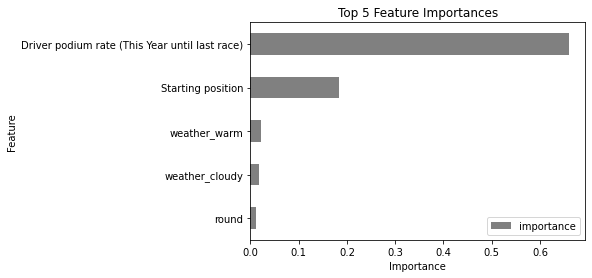

In [73]:
importances = GB.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': cols,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(5)

ax =feature_importance_df.plot(kind='barh', x='feature', y='importance', color = 'grey')
ax.invert_yaxis()

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importances')
plt.show()

In [63]:
feature_importance_df

,feature,importance
9,Driver podium rate (This Year until last race),0.660268
4,Starting position,0.183809
18,weather_warm,0.021071
22,weather_cloudy,0.017599
2,round,0.012609


In [85]:
dict_of_models = {"AdaBoost" : AdaBoost,
                  "CatBoost" : CatBoost,
                  "GradientBoosting" : GB,
                  "XGBoost" : XGBoost,
                  "DecisionTree" : DecisionTree,
                  "RandomForest" : RandomForest,
                  "SVM" : SupportVectorMachine}

# Evaluation

In [86]:
for key, value in dict_of_models.items():
    print('------------------------------------------------------')
    print("\033[1m" + key + "\033[0m")
    print('------------------------------------------------------')
    evaluation(value)
    comparison_dict['model'].append(key)

------------------------------------------------------
AdaBoost
------------------------------------------------------
[[339  35]
 [ 14  52]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       374
           1       0.60      0.79      0.68        66

    accuracy                           0.89       440
   macro avg       0.78      0.85      0.81       440
weighted avg       0.91      0.89      0.89       440

------------------------------------------------------
CatBoost
------------------------------------------------------
[[338  36]
 [ 14  52]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       374
           1       0.59      0.79      0.68        66

    accuracy                           0.89       440
   macro avg       0.78      0.85      0.80       440
weighted avg       0.90      0.89      0.89       440

------------------------------------------------------
Gradien

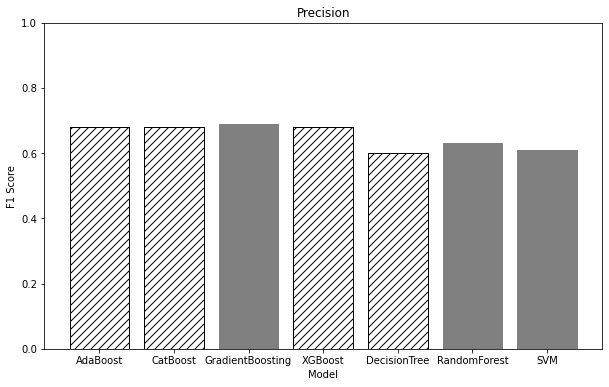

In [106]:
import matplotlib.pyplot as plt

# Données à partir du dictionnaire
models = comparison_dict['model']
scores = comparison_dict['score']

# Création du diagramme en barres avec des nuances de gris
plt.figure(figsize=(10, 6))

# Définir un motif de remplissage commun pour tous les modèles spécifiés
pattern = '///'  

bars = plt.bar(models, scores, color='white', edgecolor='black')

# Ajouter le motif de remplissage uniquement aux modèles spécifiés
specified_models = ['AdaBoost', 'CatBoost', 'XGBoost', 'DecisionTree']
for bar, model in zip(bars, models):
    if model in specified_models:
        bar.set_hatch(pattern)
    elif model in ['GradientBoosting', 'RandomForest', 'SVM']:
        bar.set_color('grey')

plt.ylim(0, 1)
# Ajout de titres et de libellés
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Affichage du diagramme
plt.show()


# Boosting model only

In [ ]:
dict_of_Boosting = {"AdaBoost" : AdaBoost,
                  "CatBoost" : CatBoost,
                  "GradientBoosting" : GB,
                  "XGBoost" : XGBoost}

In [ ]:
comparison_dict ={'model':[],
                  'score': []}

In [ ]:
for key, value in dict_of_Boosting.items():
    print('------------------------------------------------------')
    print("\033[1m" + key + "\033[0m")
    print('------------------------------------------------------')
    evaluation(value)
    comparison_dict['model'].append(key)

In [ ]:
# Données à partir du dictionnaire
models = comparison_dict['model']
scores = comparison_dict['score']

# Création du diagramme en barres avec des nuances de gris
plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color='gray')

plt.ylim(0,1)
# Ajout de titres et de libellés
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Affichage du diagramme
plt.show()

# Bagging model only

In [ ]:
dict_of_Bagging = {"DecisionTree" : DecisionTree,
                  "RandomForest" : RandomForest}

In [ ]:
comparison_dict ={'model':[],
                  'score': []}

In [ ]:
for key, value in dict_of_Bagging.items():
    print('------------------------------------------------------')
    print("\033[1m" + key + "\033[0m")
    print('------------------------------------------------------')
    evaluation(value)
    comparison_dict['model'].append(key)

In [ ]:
# Données à partir du dictionnaire
models = comparison_dict['model']
scores = comparison_dict['score']

# Création du diagramme en barres avec des nuances de gris
plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color='gray')

plt.ylim(0, max(scores) * 1.25)
# Ajout de titres et de libellés
plt.title('Precision')
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Affichage du diagramme
plt.show()

# Learning Curve

In [ ]:
## Code that plot learning curve
## No need to relaunch. Run the next following code to load the learning curve

##for key, value in dict_of_models.items():
##    print('------------------------------------------------------')
##    print("\033[1m" + key + "\033[0m")
##    print('------------------------------------------------------')
##    learningcurve(key,value)

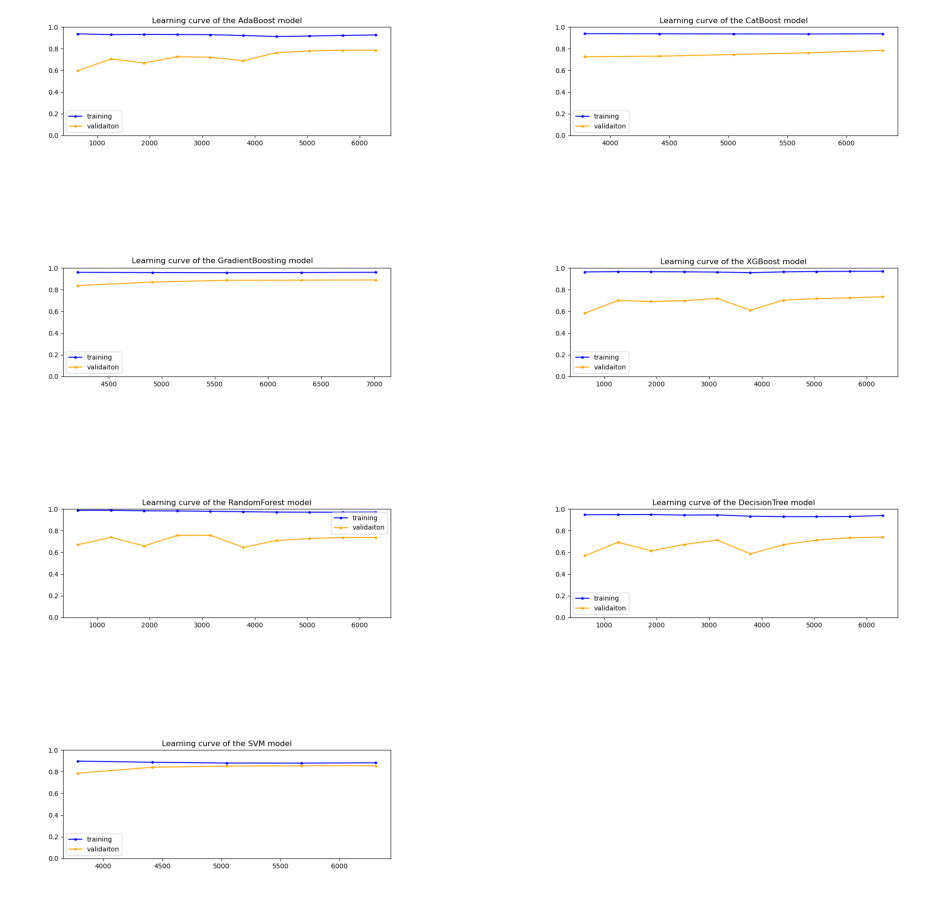

In [16]:
from IPython.display import Image, display
from PIL import Image as PILImage
import matplotlib.pyplot as plt

image1 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/AdaBoost.png')
image2 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/CatBoost.png')
image3 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/GradientBoosting.png')
image4 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/XGBoost.png')
image5 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/RandomForest.png')
image6 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/DecisionTree.png')
image7 = PILImage.open('C:/Users/33782/Desktop/Mémoire F1/Learning curve/SVM.png')

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

axs[0,0].imshow(image1)
axs[0,0].axis('off')
axs[0,1].imshow(image2)
axs[0,1].axis('off')
axs[1,0].imshow(image3)
axs[1,0].axis('off')
axs[1,1].imshow(image4)
axs[1,1].axis('off')
axs[2,0].imshow(image5)
axs[2,0].axis('off')
axs[2,1].imshow(image6)
axs[2,1].axis('off')
axs[3,0].imshow(image7)
axs[3,0].axis('off')
axs[3, 1].axis('off')
plt.show()

In [118]:
import joblib

In [124]:
joblib.dump(GB, 'GB.joblib')

['GB.joblib']

In [125]:
model = joblib.load('GB.joblib')

weather_warm
0    16761
1     9638
Name: count, dtype: int64

In [126]:
yhat = model.predict(X_test_scaled)
yhat

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,